In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("A_Trim_Data.csv",index_col=0)
df.head()

,L,W,H,T,Part Packaging volume,Weight,Surface finish,Acoustic,NVH Material pasted at border,Fastner Quantity,Assembly Process,Shape (Straight/Y shape),Quantity,Lug,Locator,Arrestor,Deflection in mm top for 22N,Deflection in mm top for 120N,Cost
Vehicle,,,,,,,,,,,,,,,,,,,
MS Brezza,690,135,58,1.3,5402700,0.148,Textured,Yes,No,0,Difficult,Straight,3,1,2,3,1.20,4.45,44.38
Mahindra KUV100,605,120,60,2.1,4356000,0.204,No,No,No,0,Easy,Straight,2,1,1,2,0.45,1.65,53.16
Hyundai Creta New,720,112,62,2.4,4999680,0.227,No,No,No,0,Easy,Straight,2,0,3,2,0.30,0.85,57.94
Toyota Fortuner,734,154,74,2.4,8364664,0.220,Textured,No,Yes,0,Easy,Straight,2,0,2,2,0.30,0.85,59.79
Hyundai Creta (Old),730,135,51,2.4,5026050,0.278,Textured,Yes,No,0,Easy,Straight,2,2,1,10,0.30,0.85,67.19


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, MS Brezza to Ford Ecosport
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   L                              19 non-null     int64  
 1   W                              19 non-null     int64  
 2   H                              19 non-null     int64  
 3   T                              19 non-null     float64
 4   Part Packaging volume          19 non-null     int64  
 5   Weight                         19 non-null     float64
 6   Surface finish                 19 non-null     object 
 7   Acoustic                       19 non-null     object 
 8   NVH Material pasted at border  19 non-null     object 
 9   Fastner Quantity               19 non-null     int64  
 10  Assembly Process               19 non-null     object 
 11  Shape (Straight/Y shape)       19 non-null     object 
 12  Quantity                       19 non-

No null values in dataframe

In [6]:
# Delete Features with Zero Variance
for column in df.columns:
    check = len(np.unique(df[column]))
    if check==1:
        df.drop(column,axis=1, inplace=True)

In [7]:
df.shape

(19, 19)

Plot distribution of all numerical variables

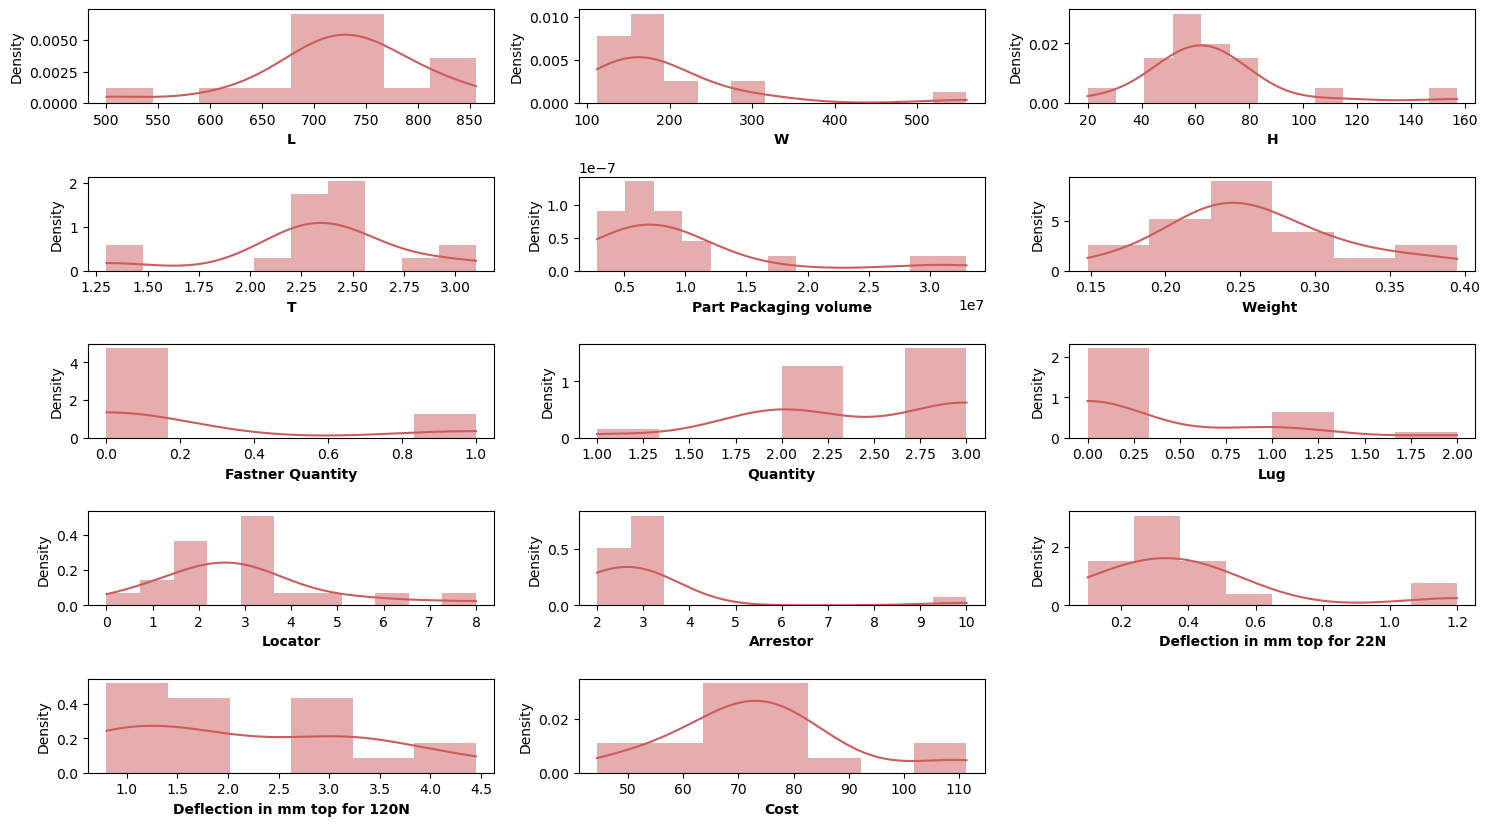

In [8]:
num_col = [col for col in df.columns if df[col].dtype != 'O']
plt.figure(figsize=(15, 100))
for i, col in enumerate(num_col):
    plt.subplot(60, 3, i+1)
    sns.histplot(x=df[col], color='indianred', kde=True, stat="density", linewidth=0)
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

Here the features and label varies with respect to the design of a model. Based on the label column it is visible all possible categories are taken.

In [9]:
x = df.drop('Cost', axis=1)
y = df['Cost']

In [10]:
x_num_col = x.select_dtypes(exclude="object").columns

x_cat_col = x.select_dtypes(object).columns

In [11]:
# Convert categorical columns to numerical columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
x[x_cat_col] = x[x_cat_col].apply(le.fit_transform)
x.head()

,L,W,H,T,Part Packaging volume,Weight,Surface finish,Acoustic,NVH Material pasted at border,Fastner Quantity,Assembly Process,Shape (Straight/Y shape),Quantity,Lug,Locator,Arrestor,Deflection in mm top for 22N,Deflection in mm top for 120N
Vehicle,,,,,,,,,,,,,,,,,,
MS Brezza,690,135,58,1.3,5402700,0.148,1,1,0,0,0,0,3,1,2,3,1.20,4.45
Mahindra KUV100,605,120,60,2.1,4356000,0.204,0,0,0,0,1,0,2,1,1,2,0.45,1.65
Hyundai Creta New,720,112,62,2.4,4999680,0.227,0,0,0,0,1,0,2,0,3,2,0.30,0.85
Toyota Fortuner,734,154,74,2.4,8364664,0.220,1,0,1,0,1,0,2,0,2,2,0.30,0.85
Hyundai Creta (Old),730,135,51,2.4,5026050,0.278,1,1,0,0,1,0,2,2,1,10,0.30,0.85


In [12]:
from sklearn.preprocessing import RobustScaler
x_rob = x
robustscaler = RobustScaler()
x_rob[x_num_col] = robustscaler.fit_transform(x_rob[x_num_col])

In [13]:
from sklearn.preprocessing import StandardScaler
x_std = x
standardscaler = StandardScaler()
x_std[x_num_col] = standardscaler.fit_transform(x_std[x_num_col])

Create functions for model training and evaluation

In [14]:
def evaluate_reg(true, pred):
    MAE = mean_absolute_error(true, pred)
    MSE = mean_squared_error(true, pred)
    RMSE = np.sqrt(mean_squared_error(true, pred))
    R2 = r2_score(true, pred)
    return MAE, MSE, RMSE, R2

In [15]:
def evaluate_models(x,y, models):
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(x_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)

        # Training set performance
        model_train_MAE, model_train_MSE, model_train_RMSE, model_train_R2 = evaluate_reg(y_train, y_train_pred)
        

        # Test set performance
        model_test_MAE, model_test_MSE, model_test_RMSE, model_test_R2 = evaluate_reg(y_test, y_test_pred)
        
        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Mean Absolute Error: {:.4f}".format(model_train_MAE))
        print('- Mean Squared Error: {:.4f}'.format(model_train_MSE)) 
        print('- Root Mean Squared Error: {:.4f}'.format(model_train_RMSE))
        print('- R2 Value: {:.4f}'.format(model_train_R2))

        print('----------------------------------')

        print('Model performance for Test set')
        print("- Mean Absolute Error: {:.4f}".format(model_test_MAE))
        print('- Mean Squared Error: {:.4f}'.format(model_test_MSE)) 
        print('- Root Mean Squared Error: {:.4f}'.format(model_test_RMSE))
        print('- R2 Value: {:.4f}'.format(model_test_R2))
        accuracy_list.append(model_test_R2)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=["Accuracy"],ascending=False)
        
    return report    

In [16]:
models = {
    "Linear Regression": LinearRegression(),
     "Support Vector": SVR(),
     "Lasso Regression": Lasso(alpha = 0.001, fit_intercept=True, normalize = True),
    "Ridge Regression": Ridge(alpha = 0.001, fit_intercept=True, normalize = True),
    "ElasticNet Regression": ElasticNet(l1_ratio=0.1, alpha = 0.001, fit_intercept=True, normalize = True)}

In [17]:
models1 = {
    "Random Forest": RandomForestRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoostRegression": CatBoostRegressor()}

In [18]:
report_final_rob = evaluate_models(x_rob,y, models)

Linear Regression
Model performance for Training set
- Mean Absolute Error: 0.0000
- Mean Squared Error: 0.0000
- Root Mean Squared Error: 0.0000
- R2 Value: 1.0000
----------------------------------
Model performance for Test set
- Mean Absolute Error: 7.6514
- Mean Squared Error: 68.3238
- Root Mean Squared Error: 8.2658
- R2 Value: 0.5049


Support Vector
Model performance for Training set
- Mean Absolute Error: 9.5403
- Mean Squared Error: 193.5521
- Root Mean Squared Error: 13.9123
- R2 Value: 0.0914
----------------------------------
Model performance for Test set
- Mean Absolute Error: 15.0898
- Mean Squared Error: 375.8007
- Root Mean Squared Error: 19.3856
- R2 Value: -1.7232


Lasso Regression
Model performance for Training set
- Mean Absolute Error: 0.0349
- Mean Squared Error: 0.0018
- Root Mean Squared Error: 0.0424
- R2 Value: 1.0000
----------------------------------
Model performance for Test set
- Mean Absolute Error: 6.2230
- Mean Squared Error: 51.8947
- Root Mean Sq

In [19]:
report_final_rob

,Model Name,Accuracy
4,ElasticNet Regression,0.801424
3,Ridge Regression,0.745129
2,Lasso Regression,0.623945
0,Linear Regression,0.504892
1,Support Vector,-1.723240


In [20]:
# Let's perform a cross-validation to find the best combination of alpha and l1_ratio
alpha_values = {'alpha':[0.001, 0.01, 0.05, 0.06, 0.08, 1],
 'l1_ratio':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}

cv_model = GridSearchCV(ElasticNet(), alpha_values, scoring='r2', cv=10)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_rob,y,test_size=0.2,random_state=42)
cv_model.fit(x_train, y_train).best_params_

{'alpha': 0.001, 'l1_ratio': 0.1}

In [22]:
model = ElasticNet(l1_ratio=0.1, alpha = 0.001, fit_intercept=True, normalize = True)
model.fit(x_train, y_train)

ElasticNet(alpha=0.001, l1_ratio=0.1, normalize=True)

In [23]:
# r2 score on training dataset
print(r2_score(y_train, model.predict(x_train)))
print(r2_score(y_test, model.predict(x_test)))

0.9971936075698378
0.8014237925005471


5 features, Weightage of 72.22%


<AxesSubplot: >

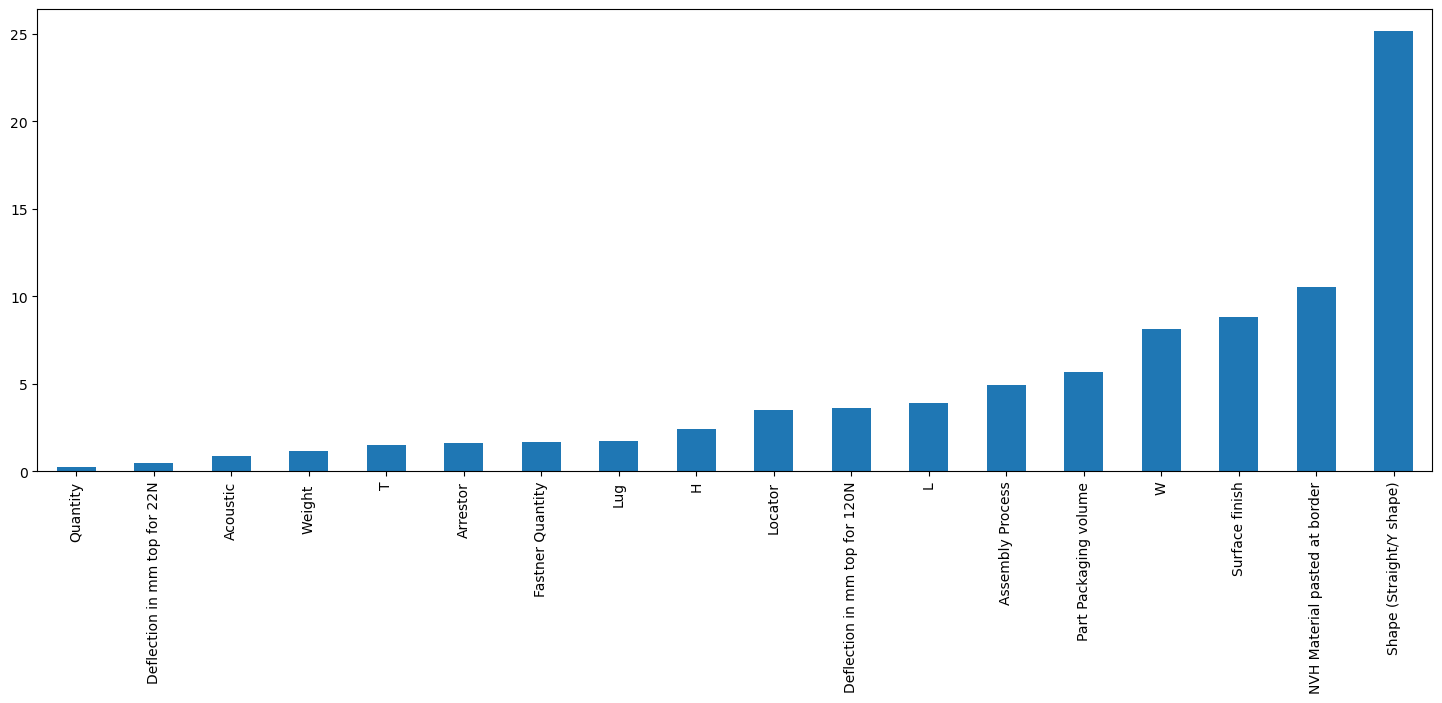

In [24]:
feature_importance = pd.Series(index = x_train.columns, data = np.abs(model.coef_))

n_selected_features = (feature_importance>5).sum()
print('{0:d} features, Weightage of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(19).plot(kind = 'bar', figsize = (18,6))

In [25]:
report_final = evaluate_models(x,y, models1)

Random Forest
Model performance for Training set
- Mean Absolute Error: 3.0343
- Mean Squared Error: 13.4387
- Root Mean Squared Error: 3.6659
- R2 Value: 0.9369
----------------------------------
Model performance for Test set
- Mean Absolute Error: 9.4889
- Mean Squared Error: 169.5441
- Root Mean Squared Error: 13.0209
- R2 Value: -0.2286


Decision Tree
Model performance for Training set
- Mean Absolute Error: 0.0000
- Mean Squared Error: 0.0000
- Root Mean Squared Error: 0.0000
- R2 Value: 1.0000
----------------------------------
Model performance for Test set
- Mean Absolute Error: 7.3100
- Mean Squared Error: 83.2803
- Root Mean Squared Error: 9.1258
- R2 Value: 0.3965


Gradient Boosting
Model performance for Training set
- Mean Absolute Error: 0.0018
- Mean Squared Error: 0.0000
- Root Mean Squared Error: 0.0021
- R2 Value: 1.0000
----------------------------------
Model performance for Test set
- Mean Absolute Error: 7.9420
- Mean Squared Error: 116.9214
- Root Mean Squared 

In [26]:
report_final

,Model Name,Accuracy
1,Decision Tree,0.396509
2,Gradient Boosting,0.152729
3,XGBRegressor,-0.081393
0,Random Forest,-0.228601
4,CatBoostRegression,-0.956184


In [27]:
report_final_std = evaluate_models(x_std,y, models)

Linear Regression
Model performance for Training set
- Mean Absolute Error: 0.0000
- Mean Squared Error: 0.0000
- Root Mean Squared Error: 0.0000
- R2 Value: 1.0000
----------------------------------
Model performance for Test set
- Mean Absolute Error: 7.6514
- Mean Squared Error: 68.3238
- Root Mean Squared Error: 8.2658
- R2 Value: 0.5049


Support Vector
Model performance for Training set
- Mean Absolute Error: 9.5403
- Mean Squared Error: 193.5521
- Root Mean Squared Error: 13.9123
- R2 Value: 0.0914
----------------------------------
Model performance for Test set
- Mean Absolute Error: 15.0898
- Mean Squared Error: 375.8007
- Root Mean Squared Error: 19.3856
- R2 Value: -1.7232


Lasso Regression
Model performance for Training set
- Mean Absolute Error: 0.0349
- Mean Squared Error: 0.0018
- Root Mean Squared Error: 0.0424
- R2 Value: 1.0000
----------------------------------
Model performance for Test set
- Mean Absolute Error: 6.2230
- Mean Squared Error: 51.8947
- Root Mean Sq

In [28]:
report_final_std

,Model Name,Accuracy
4,ElasticNet Regression,0.801424
3,Ridge Regression,0.745129
2,Lasso Regression,0.623945
0,Linear Regression,0.504892
1,Support Vector,-1.723240


In [29]:
from sklearn.preprocessing import RobustScaler
x_rob_pca = x
robustscaler = RobustScaler()
x_rob_pca[x_num_col] = robustscaler.fit_transform(x_rob_pca[x_num_col])

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 [Text(0.5, 0, 'L'),
  Text(1.5, 0, 'W'),
  Text(2.5, 0, 'H'),
  Text(3.5, 0, 'T'),
  Text(4.5, 0, 'Part Packaging volume'),
  Text(5.5, 0, 'Weight '),
  Text(6.5, 0, 'Surface finish'),
  Text(7.5, 0, 'Acoustic'),
  Text(8.5, 0, 'NVH Material pasted at border'),
  Text(9.5, 0, 'Fastner Quantity'),
  Text(10.5, 0, 'Assembly Process'),
  Text(11.5, 0, 'Shape (Straight/Y shape)'),
  Text(12.5, 0, 'Quantity'),
  Text(13.5, 0, 'Lug'),
  Text(14.5, 0, 'Locator'),
  Text(15.5, 0, 'Arrestor'),
  Text(16.5, 0, 'Deflection in mm top for 22N'),
  Text(17.5, 0, 'Deflection in mm top for 120N')])

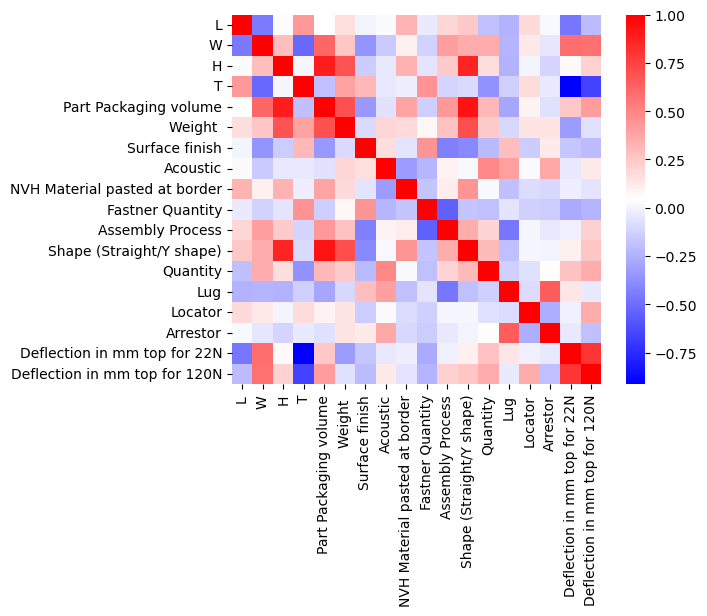

In [30]:
coorelations = x_rob_pca.corr()

sns.heatmap(data = coorelations, square=True, cmap="bwr")

plt.yticks(rotation=0)
plt.xticks(rotation=90)

In [31]:
from sklearn.decomposition import PCA
var_ratio={}
for n in range(2,19):
    pc=PCA(n_components=n)
    df_pca=pc.fit(x_rob_pca)
    var_ratio[n]=sum(df_pca.explained_variance_ratio_)

In [32]:
pip install kneed

Note: you may need to restart the kernel to use updated packages.


<Figure size 500x500 with 0 Axes>

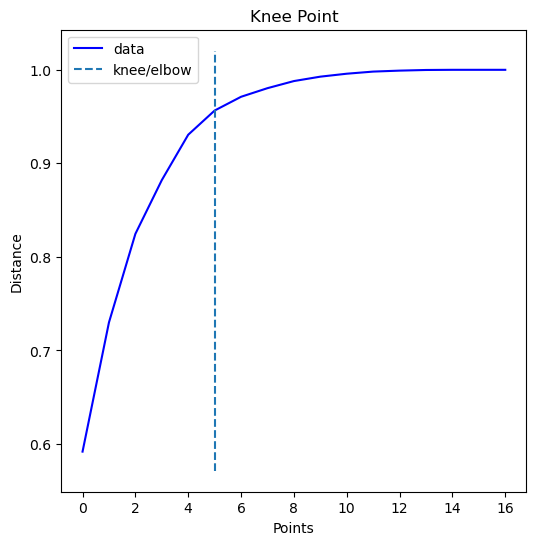

Knee Locator k = 7


In [33]:
from kneed import KneeLocator

i = np.arange(len(var_ratio))
variance_ratio= list(var_ratio.values())
components=  list(var_ratio.keys())
knee = KneeLocator(i, variance_ratio, S=1, curve='concave', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k= components[knee.knee]
print('Knee Locator k =', k)

In [34]:
pca_final=PCA(n_components=7,random_state=48)

reduced=pca_final.fit_transform(x_rob_pca)

In [35]:
report_final_pca = evaluate_models(reduced,y, models)

Linear Regression
Model performance for Training set
- Mean Absolute Error: 4.5891
- Mean Squared Error: 25.4926
- Root Mean Squared Error: 5.0490
- R2 Value: 0.8803
----------------------------------
Model performance for Test set
- Mean Absolute Error: 5.4840
- Mean Squared Error: 31.6750
- Root Mean Squared Error: 5.6281
- R2 Value: 0.7705


Support Vector
Model performance for Training set
- Mean Absolute Error: 9.5582
- Mean Squared Error: 189.0098
- Root Mean Squared Error: 13.7481
- R2 Value: 0.1127
----------------------------------
Model performance for Test set
- Mean Absolute Error: 15.2159
- Mean Squared Error: 378.0028
- Root Mean Squared Error: 19.4423
- R2 Value: -1.7392


Lasso Regression
Model performance for Training set
- Mean Absolute Error: 4.5912
- Mean Squared Error: 25.4930
- Root Mean Squared Error: 5.0491
- R2 Value: 0.8803
----------------------------------
Model performance for Test set
- Mean Absolute Error: 5.4240
- Mean Squared Error: 31.0202
- Root Mean 

In [36]:
report_final_pca

,Model Name,Accuracy
4,ElasticNet Regression,0.834338
3,Ridge Regression,0.776599
2,Lasso Regression,0.775212
0,Linear Regression,0.770467
1,Support Vector,-1.739198
